# Cleaning

## Removing time and putting the words into a single text file.

In [18]:
import os
import re

folder_path = "Dataset"

timestamp_pattern = re.compile(r'\b\d{1,2}:\d{2}(:\d{2})?\b')

for root, dirs, files in os.walk(folder_path):
    if "cleaned" in root.split(os.sep):
        continue

    for filename in files:
        if filename.endswith(".txt"):
            file_path = os.path.join(root, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()

            cleaned_text = re.sub(timestamp_pattern, '', text)  
            cleaned_text = ' '.join(cleaned_text.split()) 

            save_path = os.path.join(os.path.dirname(root), "cleaned")
            os.makedirs(save_path, exist_ok=True)

            with open(os.path.join(save_path, filename), 'w', encoding='utf-8') as file:
                file.write(cleaned_text)


---
# Preproccessing

## Tokenization

In [19]:
import nltk
import json
from nltk.tokenize import *

folder_path = "Dataset"
data = {}

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".txt"):
            if "raw_transcripts" in root.split(os.sep):
                continue
            file_path = os.path.join(root, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                tokens = nltk.tokenize.wordpunct_tokenize(text)
                filename = filename.replace(" ", "")
                data[filename] = {
                    "tokens": [],
                    "filteredTokens": [],
                    "fullText": [],
                    "sentiment": [],
                    "category": [],
                    "channelName": [],
                }
                data[filename]["tokens"].extend(tokens)
                data[filename]["fullText"].append(text)


for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                temp = json.load(file)
                txt_filename = filename.replace(".json", ".txt")
                txt_filename = txt_filename.replace(" ", "")
                if txt_filename in data:
                    data[txt_filename]["category"].append(temp["category"])
                    data[txt_filename]["channelName"].append(temp["name"])


## Stop Word filtering

In [20]:
import nltk
import string
import re
from nltk.corpus import stopwords

nltk.download("stopwords")

arabic_stopwords = set(stopwords.words("arabic"))

custom_stopwords = {
    "برضه", "بتاع", "تقول", "إنك", "الناس", "ماشي", "وأنا", "فاهم", "وكان", "عندي",
    "فا", "وكده", "طيب", "قلت", "تمام", "كانت", "كنت", "حد", "طبعا", "طب", "عندك",
    "كانت", "المكان", "بيقول", "حاجات", "يبقى", "مفيش", "الأول", "السؤال", "سؤال",
    "الحاجات", "علشان", "عارف", "فكرة", "خالص", "مثلا", "تبقي", "الموضوع", "دلوقتي",
    "مرة", "إحنا", "ليه", "إم", "جدا", "فعلا", "كتير", "أكتر", "بيقبى", "إزاي", "ال",
    "خلاص", "يقبى", "صح", "عايز", "تكون", "عشان", "يكون", "لأ", "بقى", "إللي", "إنت",
    "أوكي", "لازم", "زي", "حاجة", "بقي", "كده", "ممكن", "أه", "دي", "ده", "مش",
    "هاهاها", "يعني", "بتاعت", "إنتي","000", "دا",
}

all_stopwords = arabic_stopwords.union(custom_stopwords)

def clean_word(word):
    return re.sub(r"[^\w\s]", "", word) 

for filename in data:
    cleaned_tokens = [clean_word(word) for word in data[filename]["tokens"]] 
    filtered_tokens = [word for word in cleaned_tokens if word and word not in all_stopwords]  
    
    data[filename]["filteredTokens"].extend(filtered_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\youssef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
# We will explore to what extent does semantics and category affect a podcast
## Analysis
### These are the most common words per podcast episode,This shows that there is a relation between the most common word and category of the podcast, For example Podcasts that are more focused towards dating has keywords like "بنات" and "رجال".

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

font_path = "NotoKufiArabic-VariableFont_wght.ttf"

for filename in data:
    
    reshaped_text = arabic_reshaper.reshape(" ".join(data[filename]["filteredTokens"]))
    bidi_text = get_display(reshaped_text)

    wordcloud = WordCloud(
        width=800, height=400, font_path=font_path, background_color='white'
    ).generate(bidi_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    channel = data[filename]["channelName"][0]
    channel_folder = os.path.join("wordclouds", channel)
    os.makedirs(channel_folder, exist_ok=True)
    plt.savefig(os.path.join(channel_folder, f"wordcloud_{filename}.png"))


# In this section we will explore whether a certain category has a highly negative sentiment.

# These are the sentiments of each podcast that we analyzed, We will store them in a dictionary for further analysis.

In [22]:
from camel_tools.sentiment import SentimentAnalyzer

sa = SentimentAnalyzer.pretrained()
for filename in data:
    text = data[filename]["fullText"][0]
    sentiment = sa.predict(text)
    data[filename]["sentiment"] = sentiment
    print(f"{filename}: {sentiment}")

؟(Date❤️)بودكاستأولمرة#001-إزاينتصرففيأولمرة.txt: ['neutral']
ازايتكتشفالRedflags🚩.txt: ['neutral']
الحلقهصفر-بودكاستأولمرة-أولمرةاتقابلنا.txt: ['neutral']
الوحده_وكيفتحولهاالىقوةوسعاده.txt: ['positive']
بودكاستأولمرة#002-أولمرةاتخانت.txt: ['negative']
بودكاستأولمرة#003-اولمرهتخسرصاحبعمرك.txt: ['neutral']
بودكاستأولمرة#004-ازاينتصرففيالغربه؟.txt: ['negative']
بودكاستأولمرة#006-أولمرةتفكرفيالجواز؟.txt: ['negative']
بودكاستأولمرة#007-أولمرةليكتقوللأ.txt: ['negative']
بودكاستأولمرة#008-حلقةالعيدعنصناعةالمحتوى🤩.txt: ['neutral']
بودكاستأولمرة#009-إولمرةتطلبمساعدةمنحد؟.txt: ['neutral']
ازايتفتحمطعم؟-منهوالشيفمحمدصلاحملاكاللحمة؟-Foodcast5.txt: ['positive']
خسرفي٥مطاعموبدامنالصفرقبلنجاحمطعم(Maineماين)-Foodcast15.txt: ['positive']
خسرواكثرمن٤مليونوللاسبابديهاوعىتفتحمطعم-Foodcast17.txt: ['positive']
دكتوراسنانالصبحوفوودبلوجربليلمععمروالهادي-Foodcast7.txt: ['neutral']
رحلةمنعشلاكتشافنفسهمندكتوراسنانالىمصورالىيوتيوبر-Foodcast10.txt: ['neutral']
قصةحلمعمرعربيونجاحهالرهيبفيفيديوهاتالطبخ-Foodcast4.tx

In [23]:
from collections import defaultdict
negativeCategoryCounter = defaultdict(int)

for filename in data:
    if data[filename]["sentiment"][0] == "negative":
        for category in data[filename]["category"][0]:
            negativeCategoryCounter[category] += 1

{'Relationships': 4, 'Comedy': 11, 'Culture': 2, 'Documentary': 2, 'Educational': 2, 'Film': 4, 'TV': 4}


c:\Users\youssef\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


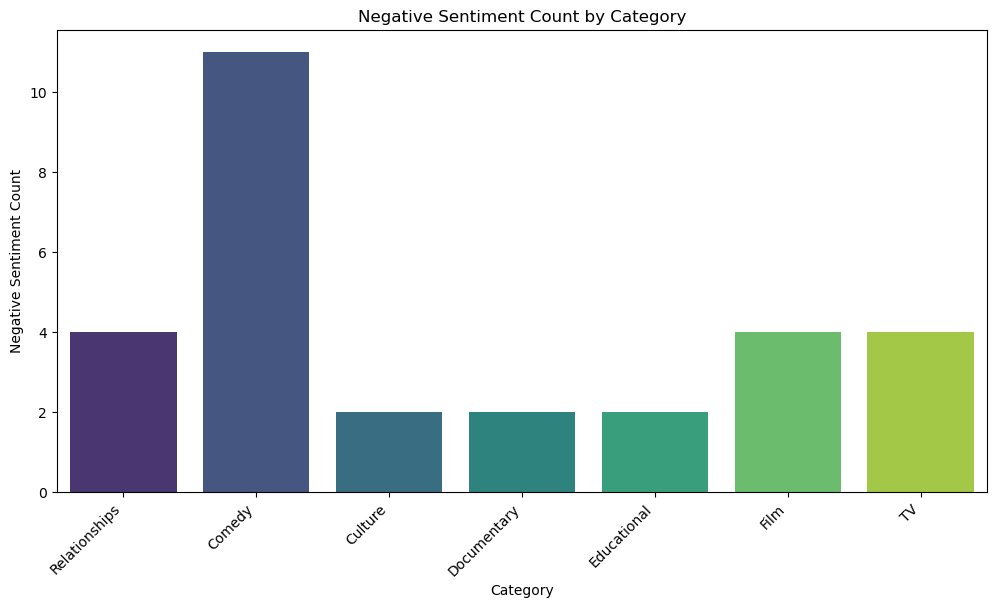

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
category_counts = dict(negativeCategoryCounter)

categories = list(category_counts.keys())
counts = list(category_counts.values())
print(category_counts)
plt.figure(figsize=(12, 6))
sns.barplot(x=categories, y=counts, palette="viridis")
plt.xticks(rotation=45, ha="right")

plt.xlabel("Category")
plt.ylabel("Negative Sentiment Count")
plt.title("Negative Sentiment Count by Category")

plt.show()


### Determine if there are channels with consistently negative sentiment like البشمهدس is 100% negative

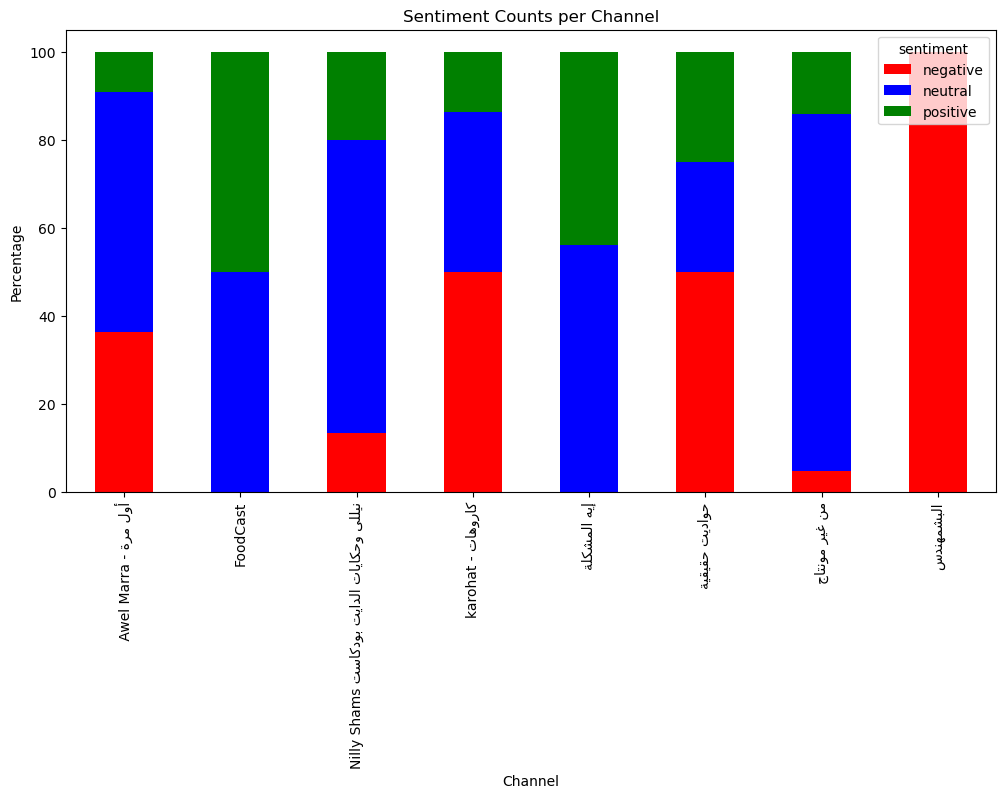

In [25]:
import pandas as pd
import arabic_reshaper
from bidi.algorithm import get_display

import matplotlib.pyplot as plt

sentiment_data = {}
channels = []
for filename in data:
    sentiment = data[filename]["sentiment"][0]
    channel = data[filename]["channelName"][0]
    if channel not in sentiment_data:
        sentiment_data[channel] = {
            "positive": 0,
            "negative": 0,
            "neutral": 0,
        }
    if sentiment == "positive":
        sentiment_data[channel]["positive"] += 1
    elif sentiment == "negative":
        sentiment_data[channel]["negative"] += 1
    else:
        sentiment_data[channel]["neutral"] += 1

df_sentiments = pd.DataFrame(sentiment_data).T.reset_index().melt(id_vars='index', var_name='sentiment', value_name='count')

df_sentiments['index'] = df_sentiments['index'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

sentiment_counts = df_sentiments.pivot_table(index='index', columns='sentiment', values='count', fill_value=0)
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in sentiment_percentages.columns])
plt.title('Sentiment Counts per Channel')
plt.ylabel('Percentage')
plt.xlabel('Channel')
plt.show()

### Investigate if similar podcasts share common catagories.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

vectorizer = TfidfVectorizer()

texts = [data[filename]["fullText"][0] for filename in data]
filenames = list(data.keys())

tfidf_matrix = vectorizer.fit_transform(texts)

similarity_matrix = cosine_similarity(tfidf_matrix)


flattened_scores = []
for i in range(len(filenames)):
    for j in range(i + 1, len(filenames)):
        flattened_scores.append((filenames[i], filenames[j], similarity_matrix[i, j]))

flattened_scores.sort(key=lambda x: x[2], reverse=True)

top_10_similar_podcasts = flattened_scores[:10]

print("Top 10 most similar podcasts overall:")
for file1, file2, score in top_10_similar_podcasts:
    categories1 = data[file1]["category"]
    categories2 = data[file2]["category"]
    print(f"Filename 1: {file1}")
    print(f"Filename 2: {file2}")
    print(f"Categories: {categories1} and {categories2}")
    print(f"Similarity Score: {score:.4f}")
    print()

Top 10 most similar podcasts overall:
Filename 1: رحلةمنعشلاكتشافنفسهمندكتوراسنانالىمصورالىيوتيوبر-Foodcast10.txt
Filename 2: مالاتعرفهعنعمروشريفوكواليسالمرحلةالجديدة-Foodcast12.txt
Categories: [['Food']] and [['Food']]
Similarity Score: 0.8839

Filename 1: دكتوراسنانالصبحوفوودبلوجربليلمععمروالهادي-Foodcast7.txt
Filename 2: قصةحلمعمرعربيونجاحهالرهيبفيفيديوهاتالطبخ-Foodcast4.txt
Categories: [['Food']] and [['Food']]
Similarity Score: 0.8810

Filename 1: قصةحلمعمرعربيونجاحهالرهيبفيفيديوهاتالطبخ-Foodcast4.txt
Filename 2: مالاتعرفهعنعمروشريفوكواليسالمرحلةالجديدة-Foodcast12.txt
Categories: [['Food']] and [['Food']]
Similarity Score: 0.8623

Filename 1: دكتوراسنانالصبحوفوودبلوجربليلمععمروالهادي-Foodcast7.txt
Filename 2: رحلةمنعشلاكتشافنفسهمندكتوراسنانالىمصورالىيوتيوبر-Foodcast10.txt
Categories: [['Food']] and [['Food']]
Similarity Score: 0.8581

Filename 1: ازايتفتحمطعم؟-منهوالشيفمحمدصلاحملاكاللحمة؟-Foodcast5.txt
Filename 2: لیهالدایتبیبوظ-خسرکلفلوسهفیمطعم-کریمامساعیل-Foodcast2.txt
Categorie

In [27]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1)


embeddings = [get_embedding(text) for text in texts]

similarity_matrix = torch.zeros((len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        similarity_matrix[i, j] = torch.nn.functional.cosine_similarity(embeddings[i], embeddings[j]).item()

flattened_scores = []
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        flattened_scores.append((filenames[i], filenames[j], similarity_matrix[i, j].item()))

flattened_scores.sort(key=lambda x: x[2], reverse=True)

top_10_similar_texts = flattened_scores[:10]

print("Top 10 most similar texts overall:")
for file1, file2, score in top_10_similar_texts:
    categories1 = data[file1]["category"]
    categories2 = data[file2]["category"]
    print(f"Filename 1: {file1}")
    print(f"Filename 2: {file2}")
    print(f"Categories: {categories1} and {categories2}")
    print(f"Similarity Score: {score:.4f}")
    print()

Top 10 most similar texts overall:
Filename 1: S1E10-اضطراباتالشهيةعدوقاتلمعياسو.txt
Filename 2: S1E3-حكايةشوشومعالدايت.txt
Categories: [[]] and [[]]
Similarity Score: 0.9728

Filename 1: افضلمشاهدافتتاحيةفيتاريخالسينما.txt
Filename 2: اكترافلاممتشوقليهافي٢٠٢٣.txt
Categories: [['Film', 'TV']] and [['Film', 'TV']]
Similarity Score: 0.9727

Filename 1: اكترافلاممتشوقليهافي٢٠٢٣.txt
Filename 2: الدليلالشاملللمصطلحاتالسينمائية.txt
Categories: [['Film', 'TV']] and [['Film', 'TV']]
Similarity Score: 0.9720

Filename 1: القشطوطهمشدايماموجوده.txt
Filename 2: يلاساحل؟.txt
Categories: [['Comedy']] and [['Comedy']]
Similarity Score: 0.9717

Filename 1: منعلبةبسكوتلمباداالىاكبرمطعمفيمصر-قصةمطعمقصرالكبابجي-Foodcast11.txt
Filename 2: منمهندسمعماريالىمبدعفيمحتوىاكل-راميسولي-Foodcast13.txt
Categories: [['Food']] and [['Food']]
Similarity Score: 0.9715

Filename 1: #1-حدوتةجدتي.txt
Filename 2: #2حواديتحقيقية-(رهنالإشارة).txt
Categories: [['Film', 'TV']] and [['Film', 'TV']]
Similarity Score: 0.9714

Fil

### Identifying Channels by Speech Style: Analyze if a podcast channel can be identified by its style of speaking. ('عز', 'وجل') by channel إيه المشكلة which is a religious podcast, and in البشمهندس addresseshis audience by ('سيدي', 'الفاضل')

In [28]:
from collections import Counter
from nltk import bigrams

channel_bigrams = {}

for filename in data:
    channel = data[filename]["channelName"][0]
    if channel not in channel_bigrams:
        channel_bigrams[channel] = []
    channel_bigrams[channel].extend(bigrams(data[filename]["filteredTokens"]))

most_common_bigrams = {channel: Counter(bigrams).most_common(1)[0] for channel, bigrams in channel_bigrams.items()}


In [29]:
for channel in most_common_bigrams:
    print(f"{channel}: {most_common_bigrams[channel]}")

 Awel Marra - أول مرة: (('ليها', 'علاقة'), 18)
FoodCast: (('الحمد', 'لله'), 276)
karohat - كاروهات: (('والله', 'العظيم'), 64)
إيه المشكلة: (('عز', 'وجل'), 456)
البشمهندس: (('سيدي', 'الفاضل'), 12)
حواديت حقيقية: (('محمود', 'فرج'), 4)
من غير مونتاج: (('بشكل', 'طبيعي'), 169)
نيللى وحكايات الدايت بودكاست Nilly Shams: (('السوشيال', 'ميديا'), 125)


###  Find the most frequently used words based on sentiment classification. We found that there is no relation between the most common words and the sentiment of the channels as you can see there is many words that are in common between each sentiment like "شاء الله" which does not affect the sentiment  of the channel

In [30]:
from collections import defaultdict, Counter
from nltk import bigrams

word_counts_by_sentiment = {
    "positive": Counter(),
    "negative": Counter(),
    "neutral": Counter()
}

bigram_counts_by_sentiment = {
    "positive": Counter(),
    "negative": Counter(),
    "neutral": Counter()
}

for filename in data:
    sentiment = data[filename]["sentiment"][0]
    filtered_tokens = data[filename]["filteredTokens"]
    word_counts_by_sentiment[sentiment].update(filtered_tokens)
    bigram_counts_by_sentiment[sentiment].update(bigrams(filtered_tokens))

most_common_words_by_sentiment = {
    sentiment: word_counts.most_common(10) 
    for sentiment, word_counts in word_counts_by_sentiment.items()
}

most_common_bigrams_by_sentiment = {
    sentiment: bigram_counts.most_common(10) 
    for sentiment, bigram_counts in bigram_counts_by_sentiment.items()
}

for sentiment, common_words in most_common_words_by_sentiment.items():
    print(f"Most common words for {sentiment} sentiment:")
    for word, count in common_words:
        print(f"{word}: {count}")
    print()

for sentiment, common_bigrams in most_common_bigrams_by_sentiment.items():
    print(f"Most common bigrams for {sentiment} sentiment:")
    for bigram, count in common_bigrams:
        print(f"{bigram}: {count}")
    print()

Most common words for positive sentiment:
الله: 1406
والله: 737
ربنا: 620
اللي: 605
ناس: 508
فيلم: 507
رمضان: 459
قوي: 414
أقول: 403
يوم: 385

Most common words for negative sentiment:
بجد: 192
الحلقة: 177
عايزة: 168
يوم: 168
عارفة: 167
والله: 155
أقول: 155
تاني: 145
قوي: 132
شوية: 118

Most common words for neutral sentiment:
الله: 1903
فيلم: 1053
والله: 862
الفيلم: 861
ربنا: 812
ناس: 776
تاني: 773
قوي: 744
أيوة: 735
شوية: 728

Most common bigrams for positive sentiment:
('شاء', 'الله'): 240
('سبحانه', 'وتعالى'): 208
('عز', 'وجل'): 198
('ربنا', 'سبحانه'): 187
('الله', 'عز'): 166
('الحمد', 'لله'): 145
('والله', 'العظيم'): 111
('صلى', 'الله'): 111
('خلي', 'بالك'): 109
('الله', 'وسلم'): 104

Most common bigrams for negative sentiment:
('شاء', 'الله'): 50
('والله', 'العظيم'): 49
('الحمد', 'لله'): 24
('طول', 'الوقت'): 21
('السوشيال', 'ميديا'): 16
('وجهة', 'نظري'): 14
('قوي', 'قوي'): 14
('ومش', 'عارفة'): 13
('أهالي', 'الحي'): 13
('عايزة', 'أقول'): 13

Most common bigrams for neutral sentime

### Find the most frequntly used words based on the catagory of the podcasts. As you can see most common words per catagory actualy show the catagory as for TV words like فيلم are common and for Food catagory words like الأكل is common

In [31]:
from collections import defaultdict, Counter

word_counts_by_category = defaultdict(Counter)

for filename in data:
    categories = data[filename]["category"][0]
    filtered_tokens = data[filename]["filteredTokens"]
    for category in categories:
        word_counts_by_category[category].update(filtered_tokens)

most_common_words_by_category = {
    category: word_counts.most_common(10)
    for category, word_counts in word_counts_by_category.items()
}

for category, common_words in most_common_words_by_category.items():
    print(f"Most common words for category {category}:")
    for word, count in common_words:
        print(f"{word}: {count}")
    print()

Most common words for category Relationships:
تاني: 106
البنت: 104
ناس: 103
الشخص: 102
واحدة: 99
والله: 91
الراجل: 88
كمان: 82
عايزة: 82
البنات: 79

Most common words for category Food:
ناس: 574
قوي: 563
الله: 529
والله: 513
حلو: 487
شوية: 447
الأكل: 414
بالظبط: 402
مطعم: 391
وبتاع: 376

Most common words for category Comedy:
بجد: 242
الحلقة: 228
عارفة: 176
يوم: 174
والله: 168
عايزة: 154
أقول: 137
قوي: 120
الله: 119
جماعة: 119

Most common words for category Self-help:
الله: 2217
ربنا: 969
والله: 782
رب: 637
رمضان: 633
اللي: 534
عز: 463
وجل: 456
قال: 448
سبحانه: 416

Most common words for category Culture:
جيلنا: 18
سيدي: 15
جيل: 13
الفاضل: 13
الإنترنت: 9
والله: 7
أقول: 7
الحج: 6
الأجيال: 6
الآباء: 6

Most common words for category Documentary:
جيلنا: 18
سيدي: 15
جيل: 13
الفاضل: 13
الإنترنت: 9
والله: 7
أقول: 7
الحج: 6
الأجيال: 6
الآباء: 6

Most common words for category Educational:
جيلنا: 18
سيدي: 15
جيل: 13
الفاضل: 13
الإنترنت: 9
والله: 7
أقول: 7
الحج: 6
الأجيال: 6
الآباء: 6

Most co